In [2]:
import json
import glob
import os
import argparse

import imgaug.augmentables as ia
import albumentations as A

from shapely import geometry
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from PIL import Image, ImageDraw
import numpy as np

import torchvision as tv
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch

import pytorch_lightning as pl
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from effdet.east import EfficientDetDoesEAST
from effdet.east import DiceLoss

In [3]:
image_folder = './train_images/'
image_files = glob.glob('./train_images/*.jpg')
with open('./train_labels.json', 'rb') as f:
    image_labels = json.load(f)

In [4]:
len(image_files), len(image_labels)

(5603, 5603)

In [5]:
def get_image_and_mask_from_name(gt_name, image_type=np.uint8, mask_type=np.uint8):
    annotations = image_labels[gt_name]
    image = Image.open(os.path.join(image_folder, f'{gt_name}.jpg')).convert('RGB')
    mask = Image.new('L', size=image.size, color=0)
    draw = ImageDraw.Draw(mask)
    for annot in annotations:
        if len(annot['points']) > 1:
            draw.polygon(tuple(tuple(xy) for xy in annot['points']), fill=255)
    np_image = np.array(image, dtype=image_type)
    np_mask = (1 * (np.array(mask) != 0)).astype(mask_type)
    return np_image, np_mask

In [6]:
def view_image_and_mask(image, mask):
    ia_mask = ia.SegmentationMapsOnImage(mask, mask.shape)
    return Image.fromarray(ia_mask.draw_on_image(image.astype(np.uint8), alpha=0.5)[0])

# Dataset

In [7]:
class ArTDataset(Dataset):
    
    
    resize_tfms = A.Resize(768, 768)
    resize_mask_tfms = A.Resize(768//2, 768//2)
    
    train_tfms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.IAAAffine(scale=(0.9, 1.1), translate_percent=(-0.1, 0.1), rotate=(-10, 10), p=0.3),
    ])
    
    lambda_tfms = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Lambda(lambda x: 2 * x -1) # for EffNet advprop
    ]) 
        
    def __init__(self, image_names:str, image_labels:dict, is_train=False):
        self.image_names = image_names
        self.image_labels = image_labels
        self.is_train = is_train
        
    def __len__(self,):
        return len(self.image_names)
        
    def __getitem__(self, idx):
        gt_name = self.image_names[idx]
        image_org, mask = get_image_and_mask_from_name(gt_name)
        
        # RESIZE
        transformed = self.resize_tfms(image=image_org, mask=mask)
        image = transformed['image']
        mask = transformed['mask']
        
        if self.is_train:
            transformed = self.train_tfms(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        # NORMALIZE
        image = self.lambda_tfms(image)
        
        
        # RESIZE MASK
        transformed = self.resize_mask_tfms(image=image_org, mask=mask)
        mask = transformed['mask']
        
        return image, mask

In [8]:
class ArTDataModule(pl.LightningDataModule):
    
    def __init__(self, image_labels, val_pct=0.1, train_bs=2, valid_bs=4):
        super().__init__()
        self.image_labels = image_labels
        self.image_names = sorted(list(image_labels.keys()))
        self.train_bs = train_bs
        self.valid_bs = valid_bs
        self.val_pct = val_pct
        
    def setup(self, stage):
        if stage == 'fit':
            train_size = round(len(self.image_names) * (1. - self.val_pct))
            self.train_dataset = ArTDataset(self.image_names[:train_size], image_labels)
            self.valid_dataset = ArTDataset(self.image_names[train_size:], image_labels)
        if stage == 'test':
            self.test_dataset = self.valid_dataset
            
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.train_bs, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.valid_bs)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.valid_bs)

In [9]:
def visualize_batch(img, mask, nrow=8):
    grid_image = tv.utils.make_grid(img, nrow=nrow)
    iam = ia.SegmentationMapsOnImage(mask.permute(1,2,0).numpy(), shape=mask.shape[1:])
    iam = iam.resize(768)
    mask = torch.tensor(iam.arr).permute(2, 0, 1)

    grid_mask = tv.utils.make_grid(mask.unsqueeze(1), nrow=nrow)

    plt.figure(figsize=(20,20))
    grid_image = (grid_image + 1)/2
    plt.imshow(grid_image.permute(1,2,0))
    plt.imshow(grid_mask.permute(1,2,0)*255, alpha=.5)

# Model

In [10]:
class DiceLoss(nn.Module):
    
    def forward(self, y_true, scores, eps=1e-8):
        # compute the actual dice score
        dims = (1, 2)
        intersection = torch.sum(scores * y_true, dims)
        cardinality = torch.sum(scores + y_true, dims)

        dice_score = 2. * intersection / (cardinality + eps)
        return torch.mean(-dice_score + 1.)

In [11]:
class EffDetSegmentationPart(EfficientDetDoesEAST):
    
    def forward(self, x):
        _, _, height, width = x.shape
        feats = self.backbone(x)

        scores = self.scores(feats)
        scores = torch.sigmoid(scores)

        score_map = scores[:, 0] # take only the segmentation scores
        return score_map

# Lightning

In [12]:
class EfficientDetDoesPL(pl.LightningModule):

    '''
        Properties needed:
            - loss_fct (nn.Module)
    '''
    
    def get_optimizer(self,) -> torch.optim.Optimizer:
        optimizer_name = self.hparams.optimizer
        lr = self.hparams.lr
        optimizer_hparams = self.hparams.optimizer_kwargs
        optimizer = getattr(torch.optim, optimizer_name)
        return optimizer(self.parameters(), lr=lr, **optimizer_hparams)
        
    def _average_key(self, outputs, key: str) -> torch.FloatTensor:
        return torch.stack([o[key] for o in outputs]).float().mean()

    def _concat_lists_by_key(self, outputs, key):
        return sum([o[key] for o in outputs], [])
    
    def _handle_batch(self, batch):
        image, gt = batch
        scores = self(image)
        
        loss = self.loss_fct(gt, scores)
        return (loss, scores)

    def _handle_eval_batch(self, batch):
        outputs = self._handle_batch(batch)
        loss, _ = outputs        
        return loss

    def _handle_eval_epoch_end(self, outputs, phase):
        loss_avg = self._average_key(outputs, f'{phase}_loss')
        return loss_avg

    def get_loss_fct(self,):
        return DiceLoss()

    ## FUNCTIONS NEEDED BY PYTORCH LIGHTNING ##

    def training_step(self, batch, batch_idx):
        self.model.backbone.freeze_bn()
        
        outputs = self._handle_batch(batch)
        loss = outputs[0]        
        self.log('train_loss', loss, on_step=True, prog_bar=False, logger=True)
        try:
            self.logger.experiment.log_metric('nep_train_loss', loss)
        except:
            pass
        return {'loss': loss}
        
    def validation_step(self, batch, batch_idx):
        loss = self._handle_eval_batch(batch)
        return {'val_loss': loss}

    def test_step(self, batch, batch_idx):
        loss = self._handle_eval_batch(batch)
        return {'test_loss': loss}

    def validation_epoch_end(self, outputs):
        loss_avg = self._handle_eval_epoch_end(outputs, phase='val')        
        self.log('val_loss', loss_avg, on_epoch=True, prog_bar=True, logger=True)

    def test_epoch_end(self, outputs):
        loss_avg = self._handle_eval_epoch_end(outputs, phase='test')
        self.log('test_loss', loss_avg, on_epoch=True, prog_bar=True, logger=True)
        return {'test_loss': loss_avg}
    
    def configure_optimizers(self) -> torch.optim.Optimizer:
        optimizer = self.get_optimizer()
        return optimizer
    
    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

In [15]:
class ArTTuner(EfficientDetDoesPL):

    default_hparams = {
        "coef": 4,
        "advprop": True,
        "factor2": False,
        "expand_bifpn": False,
        "lr": 5e-4,
        "optimizer": 'Adam',
        "optimizer_kwargs": {},
        "deterministic": False,
        "seed": 0,
    }

    def __init__(self, hparams=None, **kwargs):

        self.model_kwargs = kwargs
        self.hparams = self._construct_hparams(hparams)

        super(EfficientDetDoesPL, self).__init__()

        self.model = EffDetSegmentationPart(advprop=self.hparams.advprop,
                                            compound_coef=self.hparams.coef,
                                            expand_bifpn=self.hparams.expand_bifpn,
                                            factor2=self.hparams.factor2)

        self.loss_fct = self.get_loss_fct()

    def _construct_hparams(self, hparams):
        default_hparams = self.default_hparams.copy()

        if hparams is not None:
            default_hparams.update(hparams)

        default_hparams.update(self.model_kwargs)

        if default_hparams['deterministic']:
            pl.seed_everything(default_hparams['seed'])

        return argparse.Namespace(**default_hparams)

In [16]:
trainer_hparams = {
    'gpus': 1,
    'max_epochs': 8
}

In [17]:
dm_kwargs = {
    'val_pct': 0.1,
    'train_bs': 4,
    'valid_bs': 6
}

In [18]:
model_hparams = {
    "expand_bifpn": False, 
    "factor2": True
}

In [19]:
params = dict(**dm_kwargs, **model_hparams, **trainer_hparams)

In [20]:
model_tuner = ArTTuner(**model_hparams)

Loaded pretrained weights for efficientnet-b4


In [21]:
_ = model_tuner.model.backbone.backbone_net.requires_grad_(False)

In [22]:
data_module = ArTDataModule(image_labels, **dm_kwargs)

In [23]:
ckpt = torch.load('ckps_factor/ArT-effdet-4advprop-expand-epoch=7-val_loss=0.2035.ckpt')['state_dict']

In [24]:
model_tuner.load_state_dict(ckpt)

<All keys matched successfully>

# Checking

In [25]:
data_module.setup('fit')

In [26]:
dl_iter = iter(data_module.val_dataloader())

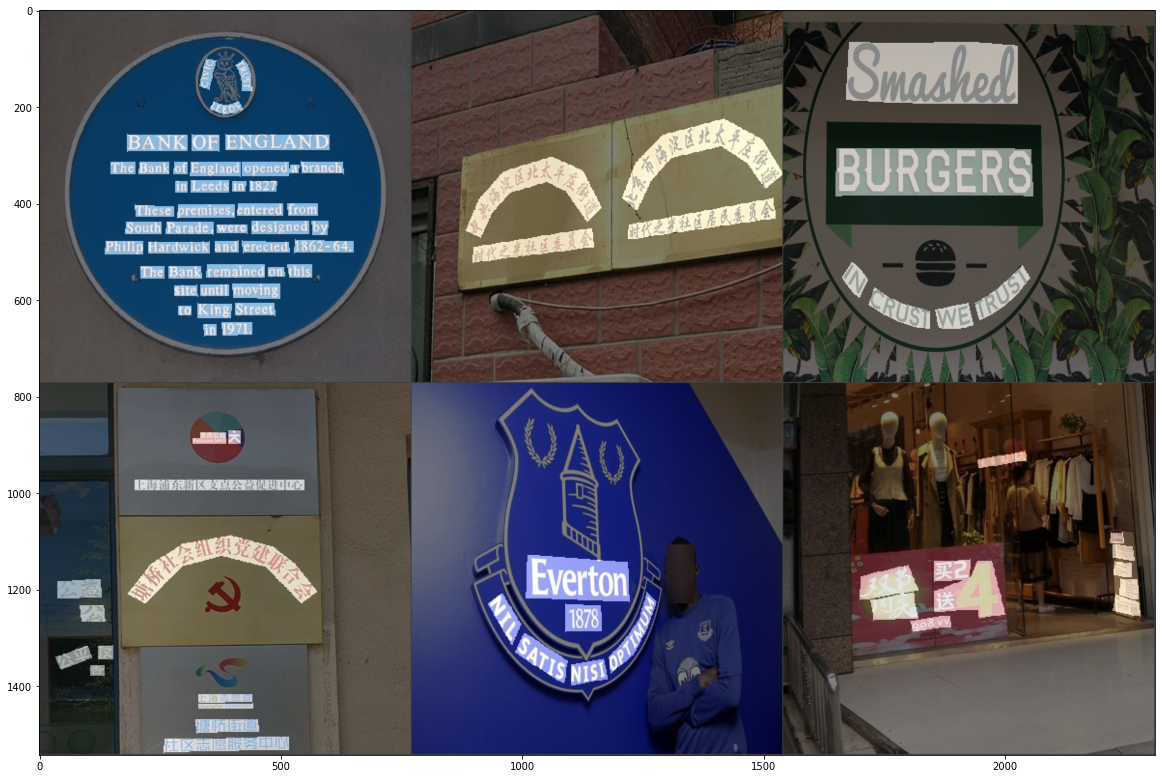

In [33]:
img, mask = next(dl_iter)
visualize_batch(img, mask, nrow=3)

In [34]:
model_tuner.eval()
with torch.no_grad():
    scores = model_tuner(img)

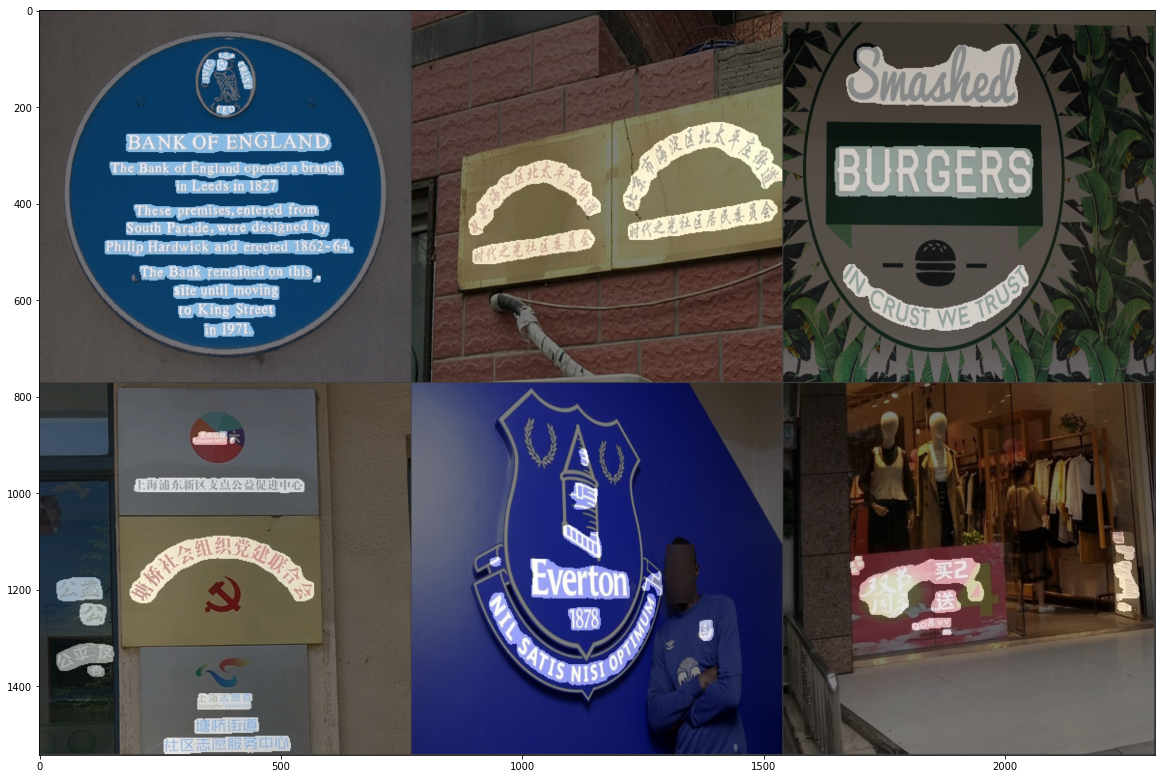

In [35]:
pred = (1*(scores > 0.5)).type(torch.uint8)
visualize_batch(img, pred, nrow=3)